# k2-18b Spectrum graph - Celerite with Names

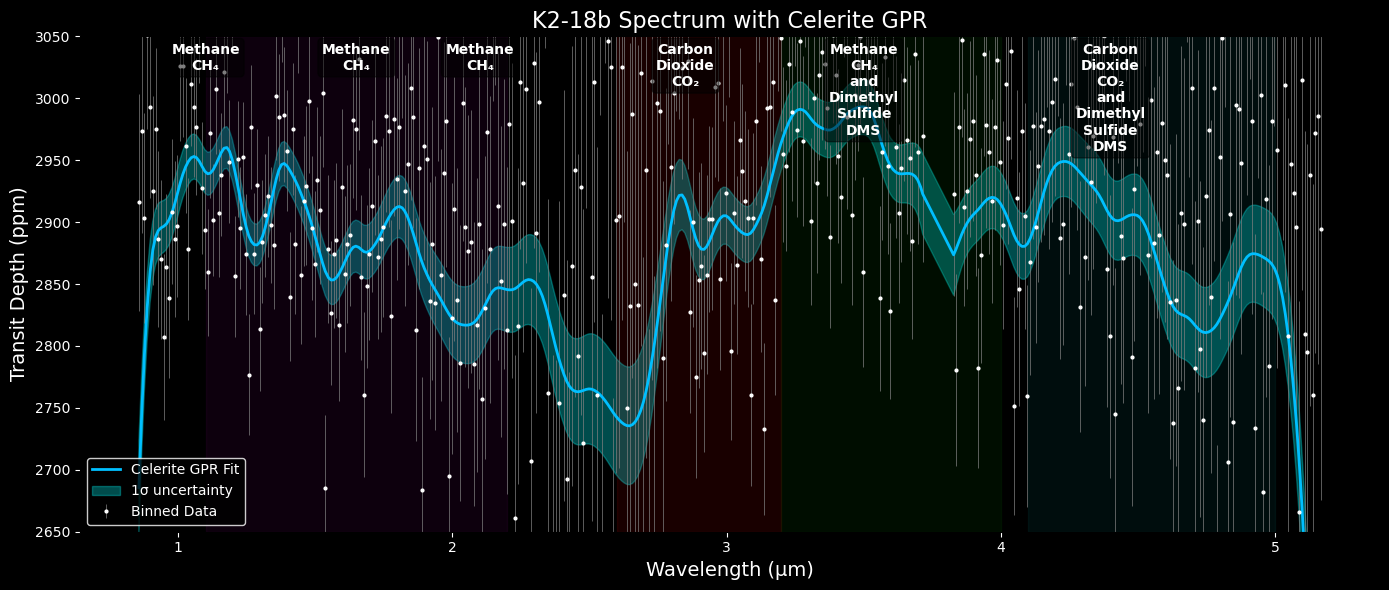

In [8]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 17 19:03:05 2025

@author: drago
"""
# @author: drago
# Description: Load native JWST spectrum of K2-18b, bin it, and fit with Celerite GPR (Matern 3/2)


import numpy as np
import matplotlib.pyplot as plt
from celerite import GP
from celerite.terms import Matern32Term

# === LOAD NATIVE-RESOLUTION JWST DATA ===
wl_soss, depth_soss, err_soss = np.loadtxt(
    "K2-18b_niriss_soss_native.txt", usecols=(0, 2, 3), unpack=True, skiprows=1)
wl_g395, depth_g395, err_g395 = np.loadtxt(
    "K2-18b_nirspec_g395h_native.txt", usecols=(0, 2, 3), unpack=True, skiprows=1)

wavelength = np.concatenate([wl_soss, wl_g395])
depth = np.concatenate([depth_soss, depth_g395])
error = np.concatenate([err_soss, err_g395])

# === SORT & CONVERT ===
idx = np.argsort(wavelength)
wavelength = wavelength[idx]
depth_ppm = depth[idx] * 1e6
error_ppm = error[idx] * 1e6

# === BINNING ===
bin_size = 0.01
bins = np.arange(wavelength.min(), wavelength.max(), bin_size)
digitized = np.digitize(wavelength, bins)

bin_centers, binned_depth, binned_error = [], [], []
for i in range(1, len(bins)):
    mask = digitized == i
    if np.any(mask):
        bin_centers.append(np.mean(wavelength[mask]))
        binned_depth.append(np.mean(depth_ppm[mask]))
        binned_error.append(np.sqrt(np.sum(error_ppm[mask]**2)) / np.sum(mask))

X = np.array(bin_centers)
y = np.array(binned_depth)
dy = np.array(binned_error)

# === CELERITE GPR ===
kernel = Matern32Term(log_sigma=np.log(np.std(y)), log_rho=np.log(0.2))
gp = GP(kernel)
gp.compute(X, yerr=dy)
y_pred, y_var = gp.predict(y, X, return_var=True)
y_std = np.sqrt(y_var)

# === PLOT ===
plt.figure(figsize=(14, 6))
plt.errorbar(X, y, yerr=dy, fmt='.', color='white', ecolor='gray', elinewidth=0.5, markersize=4, label='Binned Data')
plt.plot(X, y_pred, color='deepskyblue', lw=2, label='Celerite GPR Fit')
plt.fill_between(X, y_pred - y_std, y_pred + y_std, color='cyan', alpha=0.3, label='1σ uncertainty')

# === MOLECULAR ABSORPTION REGIONS ===
plt.axvspan(1.1, 2.2, color='purple', alpha=0.1)
plt.axvspan(2.6, 3.2, color='red', alpha=0.1)
plt.axvspan(3.2, 4.0, color='green', alpha=0.1)
plt.axvspan(4.1, 5.0, color='teal', alpha=0.1)

# === ANNOTATE MOLECULES (WHITE FONT) ===
labels = [
    (1.1, "Methane\nCH₄"),
    (1.65, "Methane\nCH₄"),
    (2.1, "Methane\nCH₄"),
    (2.85, "Carbon\nDioxide\nCO₂"),
    (3.5, "Methane\nCH₄\nand\nDimethyl\nSulfide\nDMS"),
    (4.4, "Carbon\nDioxide\nCO₂\nand\nDimethyl\nSulfide\nDMS")
]
for wav, label in labels:
    plt.text(wav, 3045, label, ha='center', va='top',
             fontsize=10, color='white', fontweight='bold',
             bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

# === STYLING ===
plt.gca().set_facecolor('black')
plt.gcf().patch.set_facecolor('black')
plt.xlabel('Wavelength (µm)', fontsize=14, color='white')
plt.ylabel('Transit Depth (ppm)', fontsize=14, color='white')
plt.title('K2-18b Spectrum with Celerite GPR', fontsize=16, color='white')
plt.tick_params(colors='white')
legend = plt.legend(facecolor='black', edgecolor='white', fontsize=10)
for text in legend.get_texts():
    text.set_color('white')
plt.ylim(2650, 3050)
plt.tight_layout()
plt.savefig("K2-18b_spectrum_GPR_labels.png", dpi=300)
plt.show()

![Alt Text](Spectra_of_exoplanet_K2-18_b_pillars.jpg)